In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import plot_importance

In [2]:
df = pd.read_csv('features_cleaned.csv')

In [3]:
df.shape

(606, 17)

In [4]:
df = df[df.Species.isin(['Clouded leopard','Snow leopard', 'Jaguar','Leopard','Lion'])]

In [5]:
df.shape

(143, 17)

In [6]:
df.columns

Index(['Partials', 'Zero_Crossings', 'Duration', 'Amp_range', 'Avg_amp',
       'Freq_range', 'Pulses_per_Sec', 'MFCC', 'Spectral Rolloff',
       'Melspectrogram', 'Spectral Contrast', 'Chroma_StFt', 'Tonnetz', 'Sex',
       'Age', 'Species', 'Call'],
      dtype='object')

In [7]:
X = df[pd.notnull(df['Call'])].drop(['Call','Sex','Age','Species'], axis=1)
y = df[pd.notnull(df['Call'])][['Call','Species']]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 13)
(43, 13)
(100, 2)
(43, 2)


In [10]:
print('Total Call Values')
print(df['Call'].value_counts())
print('\n')
print('Call values for Training')
print(y_train.Call.value_counts())
print('\n')
print('Call values for Testing')
print(y_test.Call.value_counts())

Total Call Values
roar       65
prusten    44
growl      20
hiss        6
puff        5
mew         3
Name: Call, dtype: int64


Call values for Training
roar       44
prusten    33
growl      13
puff        4
mew         3
hiss        3
Name: Call, dtype: int64


Call values for Testing
roar       21
prusten    11
growl       7
hiss        3
puff        1
Name: Call, dtype: int64


In [11]:
print('Calls trained for but not tested for')
print(set(np.unique(y_train.Call))-set(np.unique(y_test.Call)))
print('Calls test for but not trained for')
print(set(np.unique(y_test.Call))-set(np.unique(y_train.Call)))

Calls trained for but not tested for
{'mew'}
Calls test for but not trained for
set()


In [12]:
print('Total Species values')
print(df['Species'].value_counts())
print('\n')
print('Species values for Training')
print(y_train.Species.value_counts())
print('\n')
print('Species values for Testing')
print(y_test.Species.value_counts())

Total Species values
Leopard            45
Clouded leopard    35
Lion               34
Jaguar             22
Snow leopard        7
Name: Species, dtype: int64


Species values for Training
Leopard            29
Clouded leopard    24
Lion               23
Jaguar             17
Snow leopard        7
Name: Species, dtype: int64


Species values for Testing
Leopard            16
Clouded leopard    11
Lion               11
Jaguar              5
Name: Species, dtype: int64


In [13]:
print('Species trained for but not tested for')
print(set(np.unique(y_train.Species))-set(np.unique(y_test.Species)))
print('Species test for but not trained for')
print(set(np.unique(y_test.Species))-set(np.unique(y_train.Species)))

Species trained for but not tested for
{'Snow leopard'}
Species test for but not trained for
set()


# Vocalization Classification

## Splitting data

In [14]:
y_train1 = y_train.Call
y_test1 = y_test.Call

## LightGBM

In [15]:
import lightgbm as lgb
lgb1 = lgb.LGBMClassifier()
lgb1.fit(X_train, y_train1)

LGBMClassifier()

In [16]:
lgb1.score(X_train, y_train1)

1.0

In [17]:
lgb1.score(X_test,y_test1)

0.8604651162790697

## XGBoost

In [18]:
parameters = dict(
    objective='multi:softprob',
    random_state = 30,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.4,
    tree_method='gpu_hist')


clf1 = XGBClassifier(**parameters, n_estimators=1200)

In [19]:
clf1.fit(X_train, y_train1)

C:\Users\exant\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:41:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1200, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=30, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [20]:
clf1.score(X_train, y_train1)

1.0

In [21]:
clf1.score(X_test,y_test1)

0.7674418604651163

In [22]:
y_clf1 = clf1.predict(X_test)
prob_clf1 = clf1.predict_proba(X_test)

In [23]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_clf1))
print('3. Not tested for but predicted')
print(set(np.unique(y_clf1))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_clf1)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'hiss'}


Accuracy 0.7674418604651163


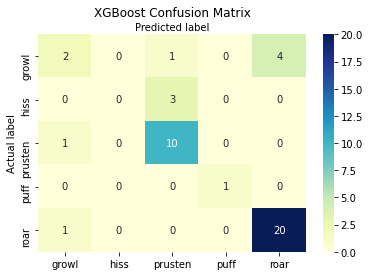

In [24]:
names = sorted(list(set(np.unique(y_test1)).union(set(y_clf1))))

print('Accuracy',clf1.score(X_test, y_test1))

cnf = confusion_matrix(y_test1, y_clf1)
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))
sns.heatmap(cnf, annot = True, xticklabels = names, cmap= "YlGnBu", yticklabels = names)
ax.xaxis.set_label_position('top')
plt.title('XGBoost Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

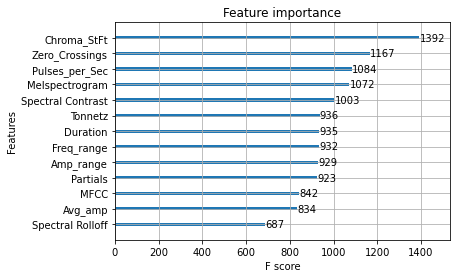

In [25]:
plot_importance(clf1)
figsize=(5,10)

## SVM

In [26]:
svm1 = SVC(probability=True)

In [27]:
svm1.fit(X_train, y_train1)

SVC(probability=True)

In [28]:
svm1.score(X_train, y_train1)

0.85

In [29]:
svm1.score(X_test, y_test1)

0.7441860465116279

In [30]:
y_svm1 = svm1.predict(X_test)
prob_svm1 = svm1.predict_proba(X_test)

In [31]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_svm1))
print('3. False Positive')
print(set(np.unique(y_svm1))-set(np.unique(y_test1)))
print('4. False Negative')
print(set(np.unique(y_test1))-set(np.unique(y_svm1)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'prusten' 'puff' 'roar']
3. False Positive
set()
4. False Negative
{'hiss'}


Accuracy 0.7441860465116279


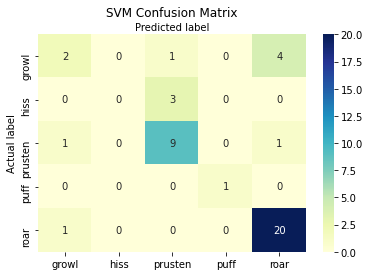

In [32]:
names = sorted(list(set(np.unique(y_test1)).union(set(y_svm1))))

print('Accuracy',svm1.score(X_test, y_test1))

cnf = confusion_matrix(y_test1, y_svm1)
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))
sns.heatmap(cnf, annot = True, xticklabels = names, cmap= "YlGnBu", yticklabels = names)
ax.xaxis.set_label_position('top')
plt.title('SVM Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [33]:
pred_df = pd.DataFrame(X_test.copy())
pred_df['Target'] = y_test1
pred_df['growl'] = prob_svm1[:,0] 
pred_df['hiss'] = prob_svm1[:,1]
pred_df['mew'] = prob_svm1[:,2]
pred_df['prusten'] = prob_svm1[:,3]
pred_df['puff'] = prob_svm1[:,4]
pred_df['roar'] = prob_svm1[:,5]
pred_df['Predicted'] = y_svm1
pred_df = pred_df[pred_df['Target'] != pred_df['Predicted']]
pred_df.to_csv('Mislabeled Panterinae Calls With SVM.csv', index=False)
pred_df.head(15)

,Partials,Zero_Crossings,Duration,Amp_range,Avg_amp,Freq_range,Pulses_per_Sec,MFCC,Spectral Rolloff,Melspectrogram,...,Chroma_StFt,Tonnetz,Target,growl,hiss,mew,prusten,puff,roar,Predicted
577,2.701873,2.055306,7.008787,1.738077,0.999292,0.272444,-0.227260,1.338170,-0.893441,0.179111,...,0.299618,0.022864,growl,0.154629,0.019913,0.017305,0.012132,0.066084,0.729936,roar
407,0.103108,-0.515473,-0.605682,1.593539,0.601862,0.517530,1.055904,1.566079,0.444750,0.268902,...,1.175930,-0.398267,prusten,0.614269,0.032522,0.026762,0.110775,0.070649,0.145022,growl
573,4.773353,2.470318,0.555847,3.489610,1.248329,1.439245,3.150666,-0.491383,0.587264,0.624672,...,-1.609842,0.570504,growl,0.249565,0.025879,0.104238,0.009973,0.067336,0.543008,roar
372,-0.386515,-0.455732,-0.476623,-0.710965,-0.643014,-0.315035,-0.409196,-0.475736,-0.198949,-0.267468,...,1.189604,-0.696705,hiss,0.005955,0.124488,0.009023,0.840939,0.010820,0.008775,prusten
376,-0.424178,-0.537129,-0.605682,-0.732839,-0.585146,-0.753001,-0.064694,-0.047318,-0.124902,-0.266568,...,1.154942,-1.740241,hiss,0.006674,0.185602,0.010829,0.782793,0.010212,0.003890,prusten
401,-0.311188,-0.556295,-0.605682,1.313578,0.527838,0.180961,-0.594935,-0.188759,-0.315786,0.530820,...,-0.371188,-0.775198,prusten,0.031022,0.061142,0.013796,0.276683,0.012627,0.604730,roar
574,-0.085208,-0.501658,-0.476623,0.282499,0.372900,-0.359014,-0.082420,0.793963,-0.237299,-0.042978,...,-0.276659,-0.233913,growl,0.049586,0.027938,0.015188,0.433618,0.022881,0.450789,prusten
464,0.931700,0.674799,1.330200,2.907062,2.451925,1.713177,0.366128,0.861109,-0.744215,1.520430,...,-0.302878,-1.004574,growl,0.456969,0.008351,0.041581,0.002847,0.039804,0.450448,roar
458,0.178434,1.055459,0.426788,2.357792,-0.184416,0.853963,1.141366,-0.446963,0.178915,-0.190837,...,-0.100714,-0.240032,growl,0.236189,0.019945,0.026154,0.037633,0.026185,0.653893,roar
375,-0.386515,-0.479441,-0.605682,-0.796778,-0.598478,-0.286325,0.488669,-0.382277,-0.029835,-0.267777,...,1.333358,-0.952526,hiss,0.007126,0.146794,0.010198,0.821287,0.010697,0.003899,prusten


## Naive Bayes

In [34]:
nb1 = GaussianNB()

In [35]:
nb1.fit(X_train, y_train1)

GaussianNB()

In [36]:
nb1.score(X_train, y_train1)

0.93

In [37]:
nb1.score(X_test, y_test1)

0.7209302325581395

In [38]:
y_nb1 = nb1.predict(X_test)
prob_nb1 = nb1.predict_proba(X_test)

In [39]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_nb1))
print('3. Not tested for but predicted')
print(set(np.unique(y_nb1))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_nb1)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


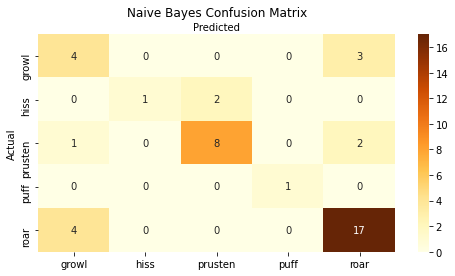

Accuracy 0.7209302325581395


In [40]:
names_nb = sorted(list(set(np.unique(y_test1)).union(set(y_nb1))))
cnf = confusion_matrix(y_test1, y_nb1)
fig, ax = plt.subplots(figsize=(8,4))

sns.heatmap(cnf, annot=True, xticklabels=names_nb, yticklabels=names_nb,cmap= "YlOrBr")
plt.title('Naive Bayes Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
print('Accuracy',nb1.score(X_test, y_test1))

In [41]:
pred_df = pd.DataFrame(X_test.copy())
pred_df['Target'] = y_test1
pred_df['growl'] = prob_nb1[:,0] 
pred_df['hiss'] = prob_nb1[:,1]
pred_df['mew'] = prob_nb1[:,2]
pred_df['prusten'] = prob_nb1[:,3]
pred_df['puff'] = prob_nb1[:,4]
pred_df['roar'] = prob_nb1[:,5]
pred_df['Predicted'] = y_nb1
pred_df = pred_df[pred_df['Target'] != pred_df['Predicted']]
pred_df.to_csv('Mislabeled Panterinae Calls With Naive Bayes.csv', index=False)
pred_df.head(15)

,Partials,Zero_Crossings,Duration,Amp_range,Avg_amp,Freq_range,Pulses_per_Sec,MFCC,Spectral Rolloff,Melspectrogram,...,Chroma_StFt,Tonnetz,Target,growl,hiss,mew,prusten,puff,roar,Predicted
407,0.103108,-0.515473,-0.605682,1.593539,0.601862,0.517530,1.055904,1.566079,0.444750,0.268902,...,1.175930,-0.398267,prusten,9.979663e-01,0.000000e+00,0.000000e+00,2.596785e-14,0.000000e+00,2.033706e-03,growl
372,-0.386515,-0.455732,-0.476623,-0.710965,-0.643014,-0.315035,-0.409196,-0.475736,-0.198949,-0.267468,...,1.189604,-0.696705,hiss,2.982533e-08,0.000000e+00,0.000000e+00,9.262923e-01,7.121354e-02,2.494137e-03,prusten
401,-0.311188,-0.556295,-0.605682,1.313578,0.527838,0.180961,-0.594935,-0.188759,-0.315786,0.530820,...,-0.371188,-0.775198,prusten,2.487869e-02,0.000000e+00,0.000000e+00,4.132017e-10,0.000000e+00,9.751213e-01,roar
574,-0.085208,-0.501658,-0.476623,0.282499,0.372900,-0.359014,-0.082420,0.793963,-0.237299,-0.042978,...,-0.276659,-0.233913,growl,1.412344e-02,0.000000e+00,0.000000e+00,7.068812e-05,0.000000e+00,9.858059e-01,roar
464,0.931700,0.674799,1.330200,2.907062,2.451925,1.713177,0.366128,0.861109,-0.744215,1.520430,...,-0.302878,-1.004574,growl,1.439530e-01,0.000000e+00,2.125175e-88,0.000000e+00,0.000000e+00,8.560470e-01,roar
379,-0.198198,-0.407504,-0.605682,2.747402,-0.244153,0.228606,1.959164,-1.921262,-0.142267,-0.222932,...,0.069013,-0.772128,prusten,2.898024e-03,3.203031e-297,0.000000e+00,5.001948e-03,1.362127e-71,9.921000e-01,roar
458,0.178434,1.055459,0.426788,2.357792,-0.184416,0.853963,1.141366,-0.446963,0.178915,-0.190837,...,-0.100714,-0.240032,growl,3.945745e-02,0.000000e+00,0.000000e+00,0.000000e+00,4.006136e-94,9.605425e-01,roar
375,-0.386515,-0.479441,-0.605682,-0.796778,-0.598478,-0.286325,0.488669,-0.382277,-0.029835,-0.267777,...,1.333358,-0.952526,hiss,6.784145e-15,1.422884e-08,0.000000e+00,1.000000e+00,1.086927e-13,1.209831e-10,prusten
433,1.948608,0.210128,0.684906,3.082510,1.470375,1.689439,0.540936,0.841702,-0.529984,0.656554,...,0.894175,0.116718,roar,9.645741e-01,0.000000e+00,1.102824e-68,0.000000e+00,0.000000e+00,3.542592e-02,growl
595,3.907098,5.161947,3.911376,3.090183,1.594722,1.541590,0.618832,0.371786,0.034500,1.302399,...,-0.673258,-0.739795,roar,9.155008e-01,0.000000e+00,2.322767e-212,0.000000e+00,0.000000e+00,8.449919e-02,growl


## Logistic Regression

In [42]:
lr1 = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight="balanced")

In [43]:
lr1.fit(X_train,y_train1)

LogisticRegression(class_weight='balanced', multi_class='ovr',
                   solver='liblinear')

In [44]:
lr1.score(X_train, y_train1)

0.9

In [45]:
lr1.score(X_test, y_test1)

0.813953488372093

In [46]:
y_lr1 = lr1.predict(X_test)
prob_lr1 = lr1.predict_proba(X_test)

In [47]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_lr1))
print('3. Not tested for but predicted')
print(set(np.unique(y_lr1))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_lr1)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.813953488372093


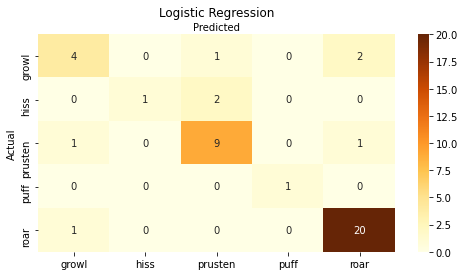

In [48]:
names_lr = sorted(list(set(np.unique(y_test1)).union(set(y_lr1))))
cnf = confusion_matrix(y_test1, y_lr1)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',lr1.score(X_test, y_test1))

sns.heatmap(cnf, annot=True, xticklabels=names_lr, yticklabels=names_lr,cmap= "YlOrBr")
plt.title('Logistic Regression')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [49]:
pred_df = pd.DataFrame(X_test.copy())
pred_df['Target'] = y_test1
pred_df['growl'] = prob_lr1[:,0] 
pred_df['hiss'] = prob_lr1[:,1]
pred_df['mew'] = prob_lr1[:,2]
pred_df['prusten'] = prob_lr1[:,3]
pred_df['puff'] = prob_lr1[:,4]
pred_df['roar'] = prob_lr1[:,5]
pred_df['Predicted'] = y_lr1
pred_df = pred_df[pred_df['Target'] != pred_df['Predicted']]
pred_df.to_csv('Mislabeled Panterinae Calls With Logistic Regression.csv', index=False)
pred_df.head(15)

,Partials,Zero_Crossings,Duration,Amp_range,Avg_amp,Freq_range,Pulses_per_Sec,MFCC,Spectral Rolloff,Melspectrogram,...,Chroma_StFt,Tonnetz,Target,growl,hiss,mew,prusten,puff,roar,Predicted
577,2.701873,2.055306,7.008787,1.738077,0.999292,0.272444,-0.227260,1.338170,-0.893441,0.179111,...,0.299618,0.022864,growl,0.106794,0.077781,0.000047,3.450088e-07,0.009986,0.805392,roar
407,0.103108,-0.515473,-0.605682,1.593539,0.601862,0.517530,1.055904,1.566079,0.444750,0.268902,...,1.175930,-0.398267,prusten,0.678088,0.088279,0.036959,1.315344e-01,0.027595,0.037544,growl
372,-0.386515,-0.455732,-0.476623,-0.710965,-0.643014,-0.315035,-0.409196,-0.475736,-0.198949,-0.267468,...,1.189604,-0.696705,hiss,0.022114,0.417350,0.017526,4.704501e-01,0.016500,0.056060,prusten
401,-0.311188,-0.556295,-0.605682,1.313578,0.527838,0.180961,-0.594935,-0.188759,-0.315786,0.530820,...,-0.371188,-0.775198,prusten,0.014739,0.042648,0.023083,4.402376e-01,0.001745,0.477548,roar
574,-0.085208,-0.501658,-0.476623,0.282499,0.372900,-0.359014,-0.082420,0.793963,-0.237299,-0.042978,...,-0.276659,-0.233913,growl,0.221034,0.043336,0.083207,4.582037e-01,0.060969,0.133251,prusten
464,0.931700,0.674799,1.330200,2.907062,2.451925,1.713177,0.366128,0.861109,-0.744215,1.520430,...,-0.302878,-1.004574,growl,0.460929,0.004279,0.018767,1.120488e-04,0.008976,0.506937,roar
375,-0.386515,-0.479441,-0.605682,-0.796778,-0.598478,-0.286325,0.488669,-0.382277,-0.029835,-0.267777,...,1.333358,-0.952526,hiss,0.034826,0.439922,0.023173,4.784339e-01,0.009319,0.014326,prusten
433,1.948608,0.210128,0.684906,3.082510,1.470375,1.689439,0.540936,0.841702,-0.529984,0.656554,...,0.894175,0.116718,roar,0.681925,0.022184,0.083746,8.542996e-04,0.007063,0.204227,growl


## KNN

In [50]:
knn1 = KNeighborsClassifier()

In [51]:
knn1.fit(X_train, y_train1)

KNeighborsClassifier()

In [52]:
knn1.score(X_train, y_train1)

0.87

In [53]:
knn1.score(X_test, y_test1)

0.7674418604651163

In [54]:
y_knn1 = knn1.predict(X_test)
prob_knn1 = knn1.predict_proba(X_test)

In [55]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_knn1))
print('3. Not tested for but predicted')
print(set(np.unique(y_knn1))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_knn1)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.7674418604651163


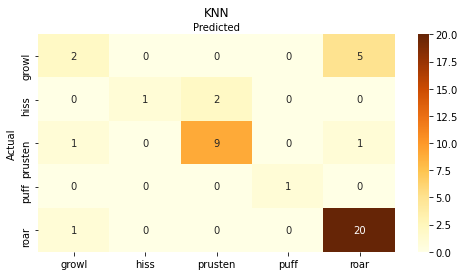

In [56]:
names_knn = sorted(list(set(np.unique(y_test1)).union(set(y_knn1))))
cnf = confusion_matrix(y_test1, y_knn1)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',knn1.score(X_test, y_test1))

sns.heatmap(cnf, annot=True, xticklabels=names_knn, yticklabels=names_knn,cmap= "YlOrBr")
plt.title('KNN')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


In [57]:
pred_df = pd.DataFrame(X_test.copy())
pred_df['Target'] = y_test1
pred_df['growl'] = prob_knn1[:,0] 
pred_df['hiss'] = prob_knn1[:,1]
pred_df['mew'] = prob_knn1[:,2]
pred_df['prusten'] = prob_knn1[:,3]
pred_df['puff'] = prob_knn1[:,4]
pred_df['roar'] = prob_knn1[:,5]
pred_df['Predicted'] = y_knn1
pred_df = pred_df[pred_df['Target'] != pred_df['Predicted']]
pred_df.to_csv('Mislabeled Panterinae Calls With KNN.csv', index=False)
pred_df.head(15)

,Partials,Zero_Crossings,Duration,Amp_range,Avg_amp,Freq_range,Pulses_per_Sec,MFCC,Spectral Rolloff,Melspectrogram,...,Chroma_StFt,Tonnetz,Target,growl,hiss,mew,prusten,puff,roar,Predicted
577,2.701873,2.055306,7.008787,1.738077,0.999292,0.272444,-0.227260,1.338170,-0.893441,0.179111,...,0.299618,0.022864,growl,0.0,0.0,0.0,0.0,0.0,1.0,roar
407,0.103108,-0.515473,-0.605682,1.593539,0.601862,0.517530,1.055904,1.566079,0.444750,0.268902,...,1.175930,-0.398267,prusten,0.8,0.0,0.0,0.0,0.0,0.2,growl
573,4.773353,2.470318,0.555847,3.489610,1.248329,1.439245,3.150666,-0.491383,0.587264,0.624672,...,-1.609842,0.570504,growl,0.2,0.0,0.2,0.0,0.0,0.6,roar
372,-0.386515,-0.455732,-0.476623,-0.710965,-0.643014,-0.315035,-0.409196,-0.475736,-0.198949,-0.267468,...,1.189604,-0.696705,hiss,0.0,0.4,0.0,0.6,0.0,0.0,prusten
401,-0.311188,-0.556295,-0.605682,1.313578,0.527838,0.180961,-0.594935,-0.188759,-0.315786,0.530820,...,-0.371188,-0.775198,prusten,0.0,0.0,0.0,0.4,0.0,0.6,roar
574,-0.085208,-0.501658,-0.476623,0.282499,0.372900,-0.359014,-0.082420,0.793963,-0.237299,-0.042978,...,-0.276659,-0.233913,growl,0.0,0.0,0.0,0.2,0.0,0.8,roar
464,0.931700,0.674799,1.330200,2.907062,2.451925,1.713177,0.366128,0.861109,-0.744215,1.520430,...,-0.302878,-1.004574,growl,0.4,0.0,0.0,0.0,0.0,0.6,roar
458,0.178434,1.055459,0.426788,2.357792,-0.184416,0.853963,1.141366,-0.446963,0.178915,-0.190837,...,-0.100714,-0.240032,growl,0.2,0.0,0.0,0.0,0.0,0.8,roar
375,-0.386515,-0.479441,-0.605682,-0.796778,-0.598478,-0.286325,0.488669,-0.382277,-0.029835,-0.267777,...,1.333358,-0.952526,hiss,0.0,0.4,0.0,0.6,0.0,0.0,prusten
433,1.948608,0.210128,0.684906,3.082510,1.470375,1.689439,0.540936,0.841702,-0.529984,0.656554,...,0.894175,0.116718,roar,0.6,0.0,0.0,0.0,0.0,0.4,growl


## Decision Tree Classifier

In [58]:
dt1 = DecisionTreeClassifier()

In [59]:
dt1.fit(X_train, y_train1)

DecisionTreeClassifier()

In [60]:
dt1.score(X_train, y_train1)

1.0

In [61]:
dt1.score(X_test, y_test1)

0.7209302325581395

In [62]:
y_dt1 = dt1.predict(X_test)
prob_dt1 = dt1.predict_proba(X_test)

In [63]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_dt1))
print('3. Not tested for but predicted')
print(set(np.unique(y_dt1))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_dt1)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'hiss' 'mew' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
{'mew'}
4. Tested for but not predicted
set()


Accuracy 0.7209302325581395


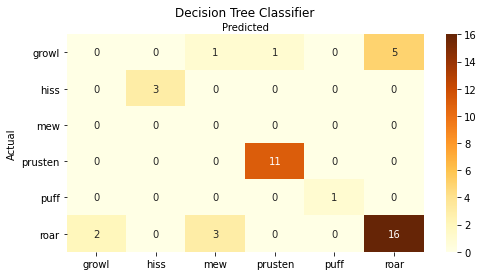

In [64]:
names_cart = sorted(list(set(np.unique(y_test1)).union(set(y_dt1))))
cnf = confusion_matrix(y_test1, y_dt1)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',dt1.score(X_test, y_test1))

sns.heatmap(cnf, annot=True, xticklabels=names_cart, yticklabels=names_cart,cmap= "YlOrBr")
plt.title('Decision Tree Classifier')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Random Forest Classifier

In [65]:
rf1 = RandomForestClassifier()

In [66]:
rf1.fit(X_train, y_train1)

RandomForestClassifier()

In [67]:
rf1.score(X_train, y_train1)

1.0

In [68]:
rf1.score(X_test, y_test1)

0.7674418604651163

In [69]:
y_rf1 = rf1.predict(X_test)
prob_rf1 = rf1.predict_proba(X_test)

In [70]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_rf1))
print('3. Not tested for but predicted')
print(set(np.unique(y_rf1))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_rf1)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'hiss'}


Accuracy 0.7674418604651163


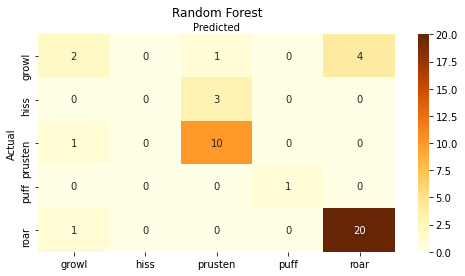

In [71]:
names_rf = sorted(list(set(np.unique(y_test1)).union(set(y_rf1))))
cnf = confusion_matrix(y_test1, y_rf1)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',rf1.score(X_test, y_test1))

sns.heatmap(cnf, annot=True, xticklabels=names_rf, yticklabels=names_rf,cmap= "YlOrBr")
plt.title('Random Forest')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


In [72]:
pred_df = pd.DataFrame(X_test.copy())
pred_df['Target'] = y_test1
pred_df['growl'] = prob_rf1[:,0] 
pred_df['hiss'] = prob_rf1[:,1]
pred_df['mew'] = prob_rf1[:,2]
pred_df['prusten'] = prob_rf1[:,3]
pred_df['puff'] = prob_rf1[:,4]
pred_df['roar'] = prob_rf1[:,5]
pred_df['Predicted'] = y_rf1
pred_df = pred_df[pred_df['Target'] != pred_df['Predicted']]
pred_df.to_csv('Mislabeled Panterinae Calls With Random Forest.csv', index=False)
pred_df.head(15)

,Partials,Zero_Crossings,Duration,Amp_range,Avg_amp,Freq_range,Pulses_per_Sec,MFCC,Spectral Rolloff,Melspectrogram,...,Chroma_StFt,Tonnetz,Target,growl,hiss,mew,prusten,puff,roar,Predicted
577,2.701873,2.055306,7.008787,1.738077,0.999292,0.272444,-0.227260,1.338170,-0.893441,0.179111,...,0.299618,0.022864,growl,0.29,0.00,0.01,0.01,0.00,0.69,roar
407,0.103108,-0.515473,-0.605682,1.593539,0.601862,0.517530,1.055904,1.566079,0.444750,0.268902,...,1.175930,-0.398267,prusten,0.59,0.04,0.00,0.29,0.00,0.08,growl
372,-0.386515,-0.455732,-0.476623,-0.710965,-0.643014,-0.315035,-0.409196,-0.475736,-0.198949,-0.267468,...,1.189604,-0.696705,hiss,0.00,0.30,0.00,0.68,0.01,0.01,prusten
376,-0.424178,-0.537129,-0.605682,-0.732839,-0.585146,-0.753001,-0.064694,-0.047318,-0.124902,-0.266568,...,1.154942,-1.740241,hiss,0.00,0.46,0.00,0.54,0.00,0.00,prusten
574,-0.085208,-0.501658,-0.476623,0.282499,0.372900,-0.359014,-0.082420,0.793963,-0.237299,-0.042978,...,-0.276659,-0.233913,growl,0.17,0.00,0.00,0.62,0.00,0.21,prusten
464,0.931700,0.674799,1.330200,2.907062,2.451925,1.713177,0.366128,0.861109,-0.744215,1.520430,...,-0.302878,-1.004574,growl,0.29,0.00,0.05,0.00,0.00,0.66,roar
458,0.178434,1.055459,0.426788,2.357792,-0.184416,0.853963,1.141366,-0.446963,0.178915,-0.190837,...,-0.100714,-0.240032,growl,0.20,0.00,0.03,0.04,0.01,0.72,roar
375,-0.386515,-0.479441,-0.605682,-0.796778,-0.598478,-0.286325,0.488669,-0.382277,-0.029835,-0.267777,...,1.333358,-0.952526,hiss,0.01,0.44,0.00,0.53,0.01,0.01,prusten
459,0.743383,-0.030266,-0.218505,2.959513,1.687206,1.625198,1.896738,0.210251,0.137189,0.694801,...,-0.066508,-0.333012,growl,0.38,0.00,0.11,0.01,0.00,0.50,roar
433,1.948608,0.210128,0.684906,3.082510,1.470375,1.689439,0.540936,0.841702,-0.529984,0.656554,...,0.894175,0.116718,roar,0.51,0.00,0.11,0.01,0.00,0.37,growl


In [73]:
#The data is unbalanced, this could be fixed by updating the class weights 
#Or getting more varied data
df['Call'].value_counts()

roar       65
prusten    44
growl      20
hiss        6
puff        5
mew         3
Name: Call, dtype: int64

# Species Classification

## Splitting data

In [74]:
y_train2 = y_train.Species
y_test2 = y_test.Species

In [75]:
## LightGBM

In [76]:
import lightgbm as lgb
lgb2 = lgb.LGBMClassifier()
lgb2.fit(X_train, y_train2)

LGBMClassifier()

In [77]:
lgb2.score(X_train, y_train2)

1.0

In [78]:
lgb2.score(X_test,y_test2)

0.8604651162790697

## XGBoost

In [79]:
parameters = dict(
    objective='multi:softprob',
    random_state = 30,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.4,
    tree_method='gpu_hist')
#eval_metric='mlogloss'

clf2 = XGBClassifier(**parameters, n_estimators=1200)

In [80]:
clf2.fit(X_train, y_train2)

C:\Users\exant\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:41:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1200, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=30, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [81]:
clf2.score(X_train, y_train2)

1.0

In [82]:
clf2.score(X_test,y_test2)

0.9069767441860465

In [83]:
y_clf2 = clf2.predict(X_test)
prob_clf2 = clf2.predict_proba(X_test)

In [84]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_clf2))
print('3. Not tested for but predicted')
print(set(np.unique(y_clf2))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_clf2)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.9069767441860465


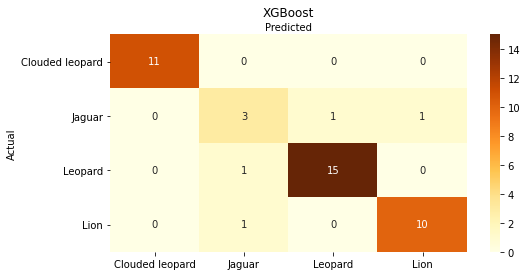

In [85]:
names = sorted(list(set(np.unique(y_test2)).union(set(y_clf2))))
cnf = confusion_matrix(y_test2, y_clf2)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',clf2.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names, yticklabels=names,cmap= "YlOrBr")
plt.title('XGBoost')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


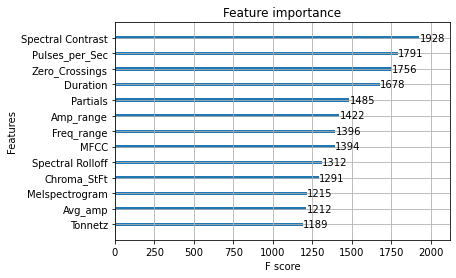

In [86]:
plot_importance(clf2)
figsize=(8,4)

## SVM

In [87]:
svm2 = SVC(probability=True)

In [88]:
svm2.fit(X_train, y_train2)

SVC(probability=True)

In [89]:
svm2.score(X_train, y_train2)

0.8

In [90]:
svm2.score(X_test, y_test2)

0.8837209302325582

In [91]:
y_svm2=svm2.predict(X_test)
prob_svm2 = svm2.predict_proba(X_test)

In [92]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_svm2))
print('3. False Positive')
print(set(np.unique(y_svm2))-set(np.unique(y_test2)))
print('4. False Negative')
print(set(np.unique(y_test2))-set(np.unique(y_svm2)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
3. False Positive
set()
4. False Negative
set()


Accuracy 0.8837209302325582


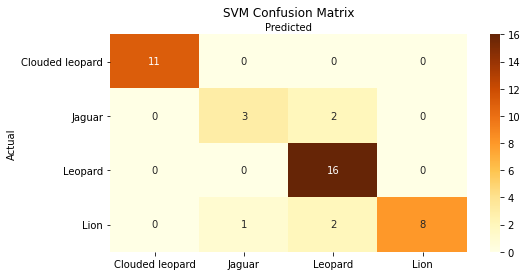

In [93]:
names_svc = sorted(list(set(np.unique(y_test2)).union(set(y_svm2))))
cnf = confusion_matrix(y_test2, y_svm2)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',svm2.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_svc, yticklabels=names_svc,cmap= "YlOrBr")
plt.title('SVM Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)



## Naive Bayes

In [94]:
nb2 = GaussianNB()

In [95]:
nb2.fit(X_train, y_train2)

GaussianNB()

In [96]:
nb2.score(X_train, y_train2)

0.71

In [97]:
nb2.score(X_test, y_test2)

0.627906976744186

In [98]:
y_nb2 = nb2.predict(X_test)
prob_nb2 = nb2.predict_proba(X_test)

In [99]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_nb2))
print('3. Not tested for but predicted')
print(set(np.unique(y_nb2))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_nb2)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
3. Not tested for but predicted
{'Snow leopard'}
4. Tested for but not predicted
set()


Accuracy 0.627906976744186


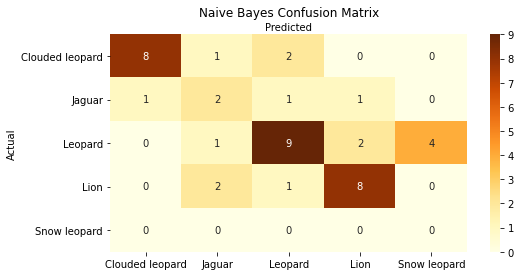

In [100]:
names_nb = sorted(list(set(np.unique(y_test2)).union(set(y_nb2))))
cnf = confusion_matrix(y_test2, y_nb2)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',nb2.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_nb, yticklabels=names_nb,cmap= "YlOrBr")
plt.title('Naive Bayes Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Logistic Regression

In [101]:
lr2 = LogisticRegression(solver='liblinear', multi_class='ovr')

In [102]:
lr2.fit(X_train,y_train2)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [103]:
lr2.score(X_train, y_train2)

0.82

In [104]:
lr2.score(X_test, y_test2)

0.7674418604651163

In [105]:
y_lr2 = lr2.predict(X_test)
prob_lr2 = lr2.predict_proba(X_test)

In [106]:
print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_lr2))
print('3. Not tested for but predicted')
print(set(np.unique(y_lr2))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_lr2)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'growl' 'hiss' 'prusten'
 'puff' 'roar']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'prusten', 'hiss', 'growl', 'puff', 'roar'}


Accuracy 0.7674418604651163


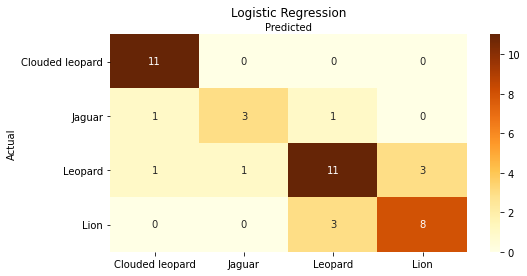

In [107]:
names_lr = sorted(list(set(np.unique(y_test2)).union(set(y_lr2))))
cnf = confusion_matrix(y_test2, y_lr2)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',lr2.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_lr, yticklabels=names_lr,cmap= "YlOrBr")
plt.title('Logistic Regression')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## KNN

In [108]:
knn2 = KNeighborsClassifier()

In [109]:
knn2.fit(X_train, y_train2)

KNeighborsClassifier()

In [110]:
knn2.score(X_train, y_train2)

0.8

In [111]:
knn2.score(X_test, y_test2)

0.813953488372093

In [112]:
y_knn2 = knn2.predict(X_test)
prob_knn2 = knn2.predict_proba(X_test)

In [113]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_knn2))
print('3. Not tested for but predicted')
print(set(np.unique(y_knn2))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_knn2)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.813953488372093


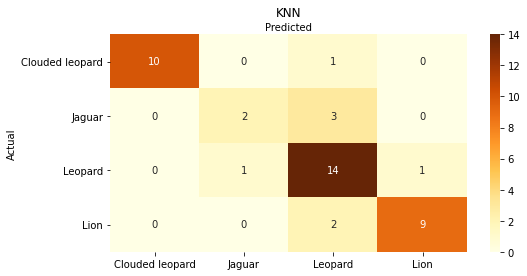

In [114]:
names_knn = sorted(list(set(np.unique(y_test2)).union(set(y_knn2))))
cnf = confusion_matrix(y_test2, y_knn2)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',knn2.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_knn, yticklabels=names_knn,cmap= "YlOrBr")
plt.title('KNN')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Decision Tree Classifier

In [115]:
dt2 = DecisionTreeClassifier()

In [116]:
dt2.fit(X_train, y_train2)

DecisionTreeClassifier()

In [117]:
dt2.score(X_train, y_train2)

1.0

In [118]:
dt2.score(X_test, y_test2)

0.813953488372093

In [119]:
y_dt2 = dt2.predict(X_test)
prob_dt2 = dt2.predict_proba(X_test)

In [120]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_dt2))
print('3. Not tested for but predicted')
print(set(np.unique(y_dt2))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_dt2)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.813953488372093


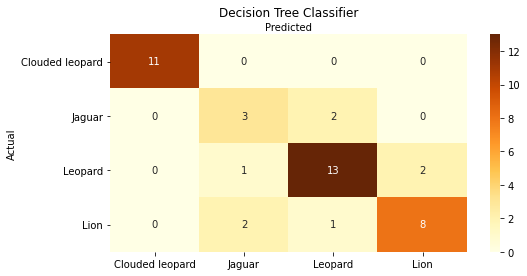

In [121]:
names_cart = sorted(list(set(np.unique(y_test2)).union(set(y_dt2))))
cnf = confusion_matrix(y_test2, y_dt2)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',dt2.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_cart, yticklabels=names_cart,cmap= "YlOrBr")
plt.title('Decision Tree Classifier')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Random Forest Classifier

In [122]:
rf2 = RandomForestClassifier()

In [123]:
rf2.fit(X_train, y_train2)

RandomForestClassifier()

In [124]:
rf2.score(X_train, y_train2)

1.0

In [125]:
rf2.score(X_test, y_test2)

0.8837209302325582

In [126]:
y_rf2 = rf2.predict(X_test)
prob_rf2 = rf2.predict_proba(X_test)

In [127]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_rf2))
print('3. Not tested for but predicted')
print(set(np.unique(y_rf2))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_rf2)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.8837209302325582


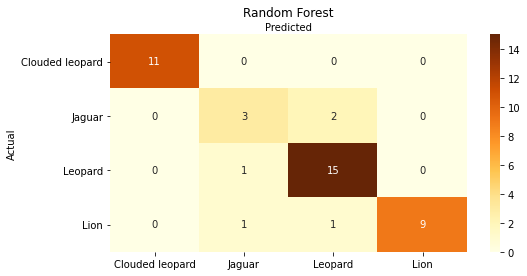

In [128]:
names_rf = sorted(list(set(np.unique(y_test2)).union(set(y_rf2))))
cnf = confusion_matrix(y_test2, y_rf2)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',rf2.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_rf, yticklabels=names_rf,cmap= "YlOrBr")
plt.title('Random Forest')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [129]:
df_test = pd.DataFrame(X_test.copy())
df_test['Target'] = y_test2
df_test['Clouded leopard'] = prob_rf2[:,0] 
df_test['Jaguar'] = prob_rf2[:,1]
df_test['Leopard'] = prob_rf2[:,2]
df_test['Lion'] = prob_rf2[:,3]
df_test['Snow leopard'] = prob_rf2[:,4]
df_test['Predicted'] = y_rf2
df_test = df_test[df_test['Target'] != df_test['Predicted']]
pred_df.to_csv('Mislabeled Panterinae Species With Random Forest.csv', index=False)
df_test.head(15)

,Partials,Zero_Crossings,Duration,Amp_range,Avg_amp,Freq_range,Pulses_per_Sec,MFCC,Spectral Rolloff,Melspectrogram,Spectral Contrast,Chroma_StFt,Tonnetz,Target,Clouded leopard,Jaguar,Leopard,Lion,Snow leopard,Predicted
407,0.103108,-0.515473,-0.605682,1.593539,0.601862,0.517530,1.055904,1.566079,0.444750,0.268902,-0.782793,1.175930,-0.398267,Jaguar,0.12,0.24,0.37,0.22,0.05,Leopard
597,0.479741,1.002003,0.168671,0.938346,-0.342325,1.443202,0.542398,-1.564324,0.424325,-0.203654,0.466191,-0.042270,0.492505,Lion,0.04,0.27,0.40,0.22,0.07,Leopard
419,0.103108,-0.516406,-0.218505,1.921980,1.855391,0.425600,-0.463531,0.437863,-1.318881,1.107530,2.558327,-0.501650,-0.248803,Jaguar,0.22,0.03,0.47,0.24,0.04,Leopard
574,-0.085208,-0.501658,-0.476623,0.282499,0.372900,-0.359014,-0.082420,0.793963,-0.237299,-0.042978,-0.124910,-0.276659,-0.233913,Lion,0.29,0.38,0.15,0.07,0.11,Jaguar
435,0.404414,6.969290,4.298552,0.814830,-0.267440,1.540642,-0.310092,-0.321139,0.720737,-0.163044,-0.506030,-0.080896,-0.408211,Leopard,0.00,0.46,0.25,0.29,0.00,Jaguar


#The data is unbalanced, this could be fixed by updating the class weights 
#Or getting more varied data
df2['Species'].value_counts()